# Kaggle - House Price Modelling
주어진 집에 대한 정보를 이용하여 집값을 예측 하는 문제

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [56]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sn

In [3]:
tr = pd.read_csv("train.csv")
tst = pd.read_csv("test.csv")

tr.shape, tst.shape

((1460, 81), (1459, 80))

한번에 처리를 하기 위해 SalePrice 열을 제외한 tr 과 tst 를 합친다. 나중에 나눌 때에는 Id를 기준으로 나눌 수 있다. 즉 Id 값이 1460보다 크면 테스트 데이터, 작으면 트레인 데이터다.

In [4]:
df = pd.concat([tr.drop("SalePrice", axis=1), tst]).reset_index(drop=True)
label = tr["SalePrice"]

df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


이전 EDA를 통해 추려낸 칼럼들을 가져온다. 다른 파일에서 저장된 데이터를 `pickle`을 통해 가져 올 수 있다.

In [5]:
# pickle로 데이터 저장
# with open("columns.pkl", "wb") as f:
#     pickle.dump(numCols + catCols, f)

# pickle로 데이터 가져오기
with open("columns.pkl", "rb") as f:
    cols = pickle.load(f)

cols

['KitchenAbvGr',
 'MasVnrArea',
 'TotalBsmtSF',
 'GarageCars',
 'Fireplaces',
 'BsmtFinSF1',
 'LotArea',
 'HalfBath',
 'GrLivArea',
 'WoodDeckSF',
 'YearBuilt',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'SaleCondition',
 'CentralAir',
 'Electrical',
 'LotShape',
 'OverallQual',
 'BldgType',
 'BsmtFinType1',
 'Heating',
 'MSZoning',
 'RoofStyle',
 'HeatingQC',
 'ExterCond',
 'BsmtCond',
 'RoofMatl',
 'Condition1',
 'LotConfig',
 'Exterior1st',
 'SaleType',
 'LandContour',
 'OverallCond',
 'Functional',
 'PavedDrive',
 'BsmtExposure',
 'HouseStyle',
 'MSSubClass',
 'MasVnrType']

## 결측치 처리
이 데이터에서 범주형 데이터의 경우 결측치로 오인되는 데이터인 경우가 많다. 확인 해 보자\.

In [6]:
categorical = list(filter(lambda x: str(df[x].dtypes) == "object", cols)) + ["MSSubClass", "OverallQual", "OverallCond"]
categorical

['SaleCondition',
 'CentralAir',
 'Electrical',
 'LotShape',
 'BldgType',
 'BsmtFinType1',
 'Heating',
 'MSZoning',
 'RoofStyle',
 'HeatingQC',
 'ExterCond',
 'BsmtCond',
 'RoofMatl',
 'Condition1',
 'LotConfig',
 'Exterior1st',
 'SaleType',
 'LandContour',
 'Functional',
 'PavedDrive',
 'BsmtExposure',
 'HouseStyle',
 'MasVnrType',
 'MSSubClass',
 'OverallQual',
 'OverallCond']

Exterior1st, SaleType, Functional, MSZoning, Electrical 은 실제 결측치인 경우다. 그러나 data_description.txt 를 읽어보면 MasVnrType, BsmtFinType1, BsmtCond, BsmtExposure 은 결측치로 오인되는 경우이다.

예를 들어 지하실이 없다는 의미로 None 문자열이 원래 들어갔는데 pandas 에서 이를 결측치로 오인한 경우이다. 따라서 fillna 를 통해 문자열로 바꾼다.

Exterior1st, SaleType, Functional, MSZoning, Electrical 의 경우엔 결측치의 개수가 매우 적기 때문에 간단하게 최빈값으로 채운다.

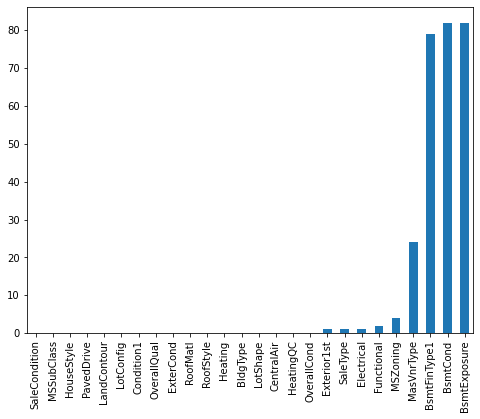

In [7]:
plt.figure(figsize=(8, 6))
df[categorical].isna().sum().sort_values().plot.bar()
plt.show()

In [8]:
tr[["MasVnrType", "BsmtFinType1", "BsmtCond", "BsmtExposure"]] = tr[["MasVnrType", "BsmtFinType1", "BsmtCond", "BsmtExposure"]].fillna("None")
df[["MasVnrType", "BsmtFinType1", "BsmtCond", "BsmtExposure"]] = df[["MasVnrType", "BsmtFinType1", "BsmtCond", "BsmtExposure"]].fillna("None")

df[["MasVnrType", "BsmtFinType1", "BsmtCond", "BsmtExposure"]].isna().sum()

MasVnrType      0
BsmtFinType1    0
BsmtCond        0
BsmtExposure    0
dtype: int64

In [9]:
# 해당 칼럼에 대해 결측치를 채울 때는 fillna 함수가 작동되지 않아 replace를 이용했다.
for col in ["Exterior1st", "SaleType", "Functional", "MSZoning", "Electrical"]:
    md = tr[col].mode().item()
    tr[col] = tr[col].replace(np.nan, md)
    df[col] = df[col].replace(np.nan, md)

df[categorical].isna().sum()

SaleCondition    0
CentralAir       0
Electrical       0
LotShape         0
BldgType         0
BsmtFinType1     0
Heating          0
MSZoning         0
RoofStyle        0
HeatingQC        0
ExterCond        0
BsmtCond         0
RoofMatl         0
Condition1       0
LotConfig        0
Exterior1st      0
SaleType         0
LandContour      0
Functional       0
PavedDrive       0
BsmtExposure     0
HouseStyle       0
MasVnrType       0
MSSubClass       0
OverallQual      0
OverallCond      0
dtype: int64

수치형 데이터에 대해서도 똑같이 채운다. 이 때 수치형 데이터에서는 최빈값이 아닌 평균값으로 채운다.

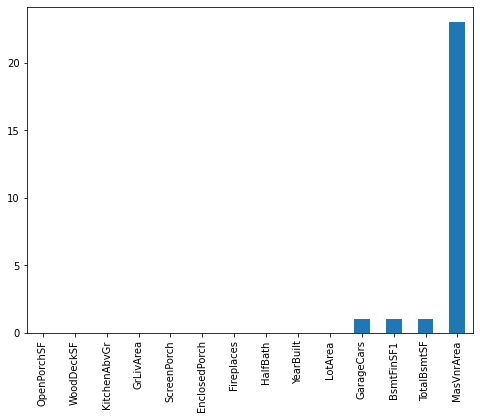

In [10]:
numeric = list(set(cols) - set(categorical))

plt.figure(figsize=(8, 6))
df[numeric].isna().sum().sort_values().plot.bar()
plt.show()

In [11]:
for col in ["BsmtFinSF1", "TotalBsmtSF", "GarageCars", "MasVnrArea"]:
    md = tr[col].mean()
    tr[col] = tr[col].replace(np.nan, md)
    df[col] = df[col].replace(np.nan, md)

df[cols].isna().sum()

KitchenAbvGr     0
MasVnrArea       0
TotalBsmtSF      0
GarageCars       0
Fireplaces       0
BsmtFinSF1       0
LotArea          0
HalfBath         0
GrLivArea        0
WoodDeckSF       0
YearBuilt        0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
SaleCondition    0
CentralAir       0
Electrical       0
LotShape         0
OverallQual      0
BldgType         0
BsmtFinType1     0
Heating          0
MSZoning         0
RoofStyle        0
HeatingQC        0
ExterCond        0
BsmtCond         0
RoofMatl         0
Condition1       0
LotConfig        0
Exterior1st      0
SaleType         0
LandContour      0
OverallCond      0
Functional       0
PavedDrive       0
BsmtExposure     0
HouseStyle       0
MSSubClass       0
MasVnrType       0
dtype: int64

모델에 적용시킬수 있게끔 이전처럼 범주형 데이터를 수치형 데이터로 바꾼다. 주의해야 할 점으론 MSSubClass 열의 경우 트레인 데이터엔 값이 150인 행이 존재하지 않는데 테스트 데이터엔 150인 행이 존재한다. 이에 대한 처리를 하지 않으면 오류가 뜬다. 디행이 이 경우가 단 하나이기 때문에 150인 행을 최빈값으로 대체한다.

In [12]:
unchanged = []
for col in categorical:
    if any(x not in tr[col].unique() for x in df[col].unique()):
        unchanged.append(col)
        continue
    keys = tr[[col, "SalePrice"]].groupby(col).mean().sort_values("SalePrice").apply(dict).to_dict()["SalePrice"].keys()
    keys = list(keys)
    tr[col] = tr[col].apply(lambda x: keys.index(x))
    df[col] = df[col].apply(lambda x: keys.index(x))
    
unchanged

['MSSubClass']

In [13]:
tr["MSSubClass"].unique(), df["MSSubClass"].unique()

(array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
        180,  40], dtype=int64),
 array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
        180,  40, 150], dtype=int64))

In [14]:
df[df["MSSubClass"] == 150].shape

(1, 80)

In [15]:
df["MSSubClass"] = df["MSSubClass"].replace(150, df["MSSubClass"].mode().item())

keys = tr[["MSSubClass", "SalePrice"]].groupby("MSSubClass").mean().sort_values("SalePrice").apply(dict).to_dict()["SalePrice"].keys()
keys = list(keys)
tr["MSSubClass"] = tr["MSSubClass"].apply(lambda x: keys.index(x))
df["MSSubClass"] = df["MSSubClass"].apply(lambda x: keys.index(x))

df[cols].dtypes

KitchenAbvGr       int64
MasVnrArea       float64
TotalBsmtSF      float64
GarageCars       float64
Fireplaces         int64
BsmtFinSF1       float64
LotArea            int64
HalfBath           int64
GrLivArea          int64
WoodDeckSF         int64
YearBuilt          int64
OpenPorchSF        int64
EnclosedPorch      int64
ScreenPorch        int64
SaleCondition      int64
CentralAir         int64
Electrical         int64
LotShape           int64
OverallQual        int64
BldgType           int64
BsmtFinType1       int64
Heating            int64
MSZoning           int64
RoofStyle          int64
HeatingQC          int64
ExterCond          int64
BsmtCond           int64
RoofMatl           int64
Condition1         int64
LotConfig          int64
Exterior1st        int64
SaleType           int64
LandContour        int64
OverallCond        int64
Functional         int64
PavedDrive         int64
BsmtExposure       int64
HouseStyle         int64
MSSubClass         int64
MasVnrType         int64


In [16]:
df[cols].isna().sum()

KitchenAbvGr     0
MasVnrArea       0
TotalBsmtSF      0
GarageCars       0
Fireplaces       0
BsmtFinSF1       0
LotArea          0
HalfBath         0
GrLivArea        0
WoodDeckSF       0
YearBuilt        0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
SaleCondition    0
CentralAir       0
Electrical       0
LotShape         0
OverallQual      0
BldgType         0
BsmtFinType1     0
Heating          0
MSZoning         0
RoofStyle        0
HeatingQC        0
ExterCond        0
BsmtCond         0
RoofMatl         0
Condition1       0
LotConfig        0
Exterior1st      0
SaleType         0
LandContour      0
OverallCond      0
Functional       0
PavedDrive       0
BsmtExposure     0
HouseStyle       0
MSSubClass       0
MasVnrType       0
dtype: int64

## 이상치 제거
Tukey Fences 방법으로 이상치 제거를 한다. 주의해야 할 점으로는 이상치 제거를 할 땐 트레인 데이터에서만 제거를 해야 한다. 테스트 데이터는 제출 용이기 때문에 빠짐없이 존재해야 하기 때문이다. 실제 이상치 제거 작업을 마치고 확인 해 본 결과 테스트 데이터는 삭제되지 않았다.

여기서는 수치형 데이터에 대해서 이상치가 존재하는 경우가 2개보다 많은 행을 제거하는 방식을 택했다.

In [17]:
def find_rows_with_multiple_outliers(data, q1, q3):
    iqr = q3-q1
    outliers = (data < (q1 - iqr*1.5)) | (data > (q3 + iqr*1.5))
    return outliers.sum(axis=1) > 2

In [18]:
numeric = list(set(cols) - set(categorical))

numeric

['GarageCars',
 'OpenPorchSF',
 'BsmtFinSF1',
 'WoodDeckSF',
 'KitchenAbvGr',
 'GrLivArea',
 'ScreenPorch',
 'EnclosedPorch',
 'Fireplaces',
 'MasVnrArea',
 'HalfBath',
 'TotalBsmtSF',
 'YearBuilt',
 'LotArea']

In [19]:
q1, q3 = tr[numeric].quantile(0.25), tr[numeric].quantile(0.75)
mask = find_rows_with_multiple_outliers(df[numeric], q1, q3)
mask = mask & (df["Id"] <= 1460)
mask.sum()

36

In [20]:
df = df.loc[~mask]
df.shape

(2883, 80)

In [28]:
label = label.loc[~mask[:1461]]

df[df["Id"] <= 1460].shape, df[df["Id"] > 1460].shape, label.shape

((1424, 80), (1459, 80), (1424,))

## 정규화
수치형 데이터에 대한 정규화를 진행한다. 이 때 쓰이는 평균과 표준편차는 오직 트레인 데이터를 이용하여 구한다.

레이블 값에는 로그를 취해줌으로써 정규화를 한다. 결과가 나오면 exponential 을 취해줌으로써 원래 스케일로 복원 가능하다.

In [21]:
tr_mn, tr_std = df[df["Id"] <= 1460][numeric].mean(), df[df["Id"] <= 1460][numeric].std()
df[numeric] = (df[numeric] - tr_mn) / tr_std

df[numeric].head()

,GarageCars,OpenPorchSF,BsmtFinSF1,WoodDeckSF,KitchenAbvGr,GrLivArea,ScreenPorch,EnclosedPorch,Fireplaces,MasVnrArea,HalfBath,TotalBsmtSF,YearBuilt,LotArea
0,0.339602,0.265649,0.657916,-0.756202,-0.206935,0.473789,-0.262816,-0.360547,-0.940595,0.590780,1.242656,-0.459705,1.056405,-0.179284
1,0.339602,-0.719339,1.305958,1.726475,-0.206935,-0.472756,-0.262816,-0.360547,0.633327,-0.585880,-0.754570,0.557097,0.155434,-0.059528
2,0.339602,-0.041151,0.133763,-0.756202,-0.206935,0.634363,-0.262816,-0.360547,0.633327,0.386666,1.242656,-0.299421,0.989666,0.112297
3,1.694204,-0.154182,-0.509514,-0.756202,-0.206935,0.488579,-0.262816,4.317377,0.633327,-0.585880,-0.754570,-0.710149,-1.880092,-0.064735
4,1.694204,0.637038,0.536408,0.843375,-0.206935,1.504847,-0.262816,-0.360547,0.633327,1.515299,1.242656,0.264078,0.956297,0.425746


In [30]:
log_label = np.log(label)
log_label.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

## PCA
상관관계 분석을 통해 80개의 피쳐를 40개로 줄였지만 40개의 피쳐도 아직 많다고 생각된다. 데이터의 특성을 보존하면서 피쳐의 개수를 줄이는 방법으로는 PCA 가 있다.

n_components 인자에 0.95를 넣음으로써 95%의 데이터 특성을 보존하면서 피쳐를 줄인다. PCA 에서의 데이터 특성이란 각 변수의 설명력의 총 합이다. 따라서 지금의 경우 설명력의 총 합이 0.95보다 높게끔 한 상태에서 피쳐의 개수를 최대한 줄이는 것이다.

다음을 보면 n_components 가 26일때 처음으로 설명력의 합이 0.95를 넘는 것을 볼 수 있다. 따라서 n_components 를 0.95로 할 경우 피쳐의 개수는 26개로 줄어들것이다.

In [24]:
for n in range(20, 31):
    pca = PCA(n_components=n)
    pca.fit(df_tr)
    print(f"sum of explained variance ratio when n_components={n}: {pca.explained_variance_ratio_.sum()}")

sum of explained variance ratio when n_components=20: 0.8999819953610568
sum of explained variance ratio when n_components=21: 0.9107585312568659
sum of explained variance ratio when n_components=22: 0.9208780329551344
sum of explained variance ratio when n_components=23: 0.9305600078145584
sum of explained variance ratio when n_components=24: 0.9396026008399208
sum of explained variance ratio when n_components=25: 0.9475113618170672
sum of explained variance ratio when n_components=26: 0.9551739250212703
sum of explained variance ratio when n_components=27: 0.962034007556847
sum of explained variance ratio when n_components=28: 0.9676635527203047
sum of explained variance ratio when n_components=29: 0.9727088465069519
sum of explained variance ratio when n_components=30: 0.9766601225279447


In [26]:
pca = PCA(n_components=0.95)
pca.fit(df_tr)
df_tr_pca = pca.transform(df_tr)
pca.explained_variance_ratio_.sum(), df_tr_pca.shape

(0.9551743453005799, (1424, 26))

In [31]:
df_tst_pca = pca.transform(df_tst)

df_tst_pca.shape

(1459, 26)

## 모델링
다음의 모델을 사용하여 비교해본다.

1. RandomForest

트리 개수와 최대 트리 깊이를 변경 해 가며 하이퍼 파라미터 튜닝을 한다. 그 결과 최대 트리 깊이 제한 없이 가장 많은 트리 개수를 사용하는 것의 성능이 가장 좋았다.

2. Gradient Boosting

충분히 큰 n_estimators 값을 사용하여 staged_predict 를 구한다. 너무 많은 weak learner 를 사용하면 **과적합 이슈**가 있기 때문에 그래플 그려서 충분히 수렴된 지점인 500을 이용한다.

3. XGBoost
4. LightGBM

(conda 를 사용 할 경우) conda install xgboost / conda install lightgbm 을 통해 설치 할 수 있다.

여기서는 staged_predict 를 구하기 어려워 GBM 에서 확인한 값인 500을 그대로 사용하기로 했다.

5. 딥러닝 모델

sklearn 에서도 딥러닝 회귀모델을 제공하여 사용 해 보았으니 크게 성능이 떨어지는 것을 확인 할 수 있다.

rmsle 값도 낮고 그래프를 그려보았을 때 극값에 대한 예측도 어느정도 잘한 LightGBM 모델을 선택했다.

In [62]:
X_tr, X_tst, y_tr, y_tst = train_test_split(df_tr_pca, log_label, test_size=0.25)
X_tr, X_tst, y_tr, y_tst = map(np.array, [X_tr, X_tst, y_tr, y_tst])

X_tr.shape, X_tst.shape

((1068, 26), (356, 26))

In [63]:
def rmsle(y, y_hat):
    log = (np.log(y) - np.log(y_hat)) ** 2
    return np.sqrt(np.mean(log))

In [64]:
# 1. RF
for n_estimators in [100, 200, 300, 400, 500]:
    for max_depth in [None, 2, 3]:
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        rf.fit(X_tr, y_tr)
        y_pred = rf.predict(X_tst)
        print(f"n_estimators={n_estimators} max_depth={max_depth} rmsle={rmsle(np.exp(y_tst), np.exp(y_pred))}")

n_estimators=100 max_depth=None rmsle=0.16775300749506133
n_estimators=100 max_depth=2 rmsle=0.261914285780218
n_estimators=100 max_depth=3 rmsle=0.23233187277012954
n_estimators=200 max_depth=None rmsle=0.16715092037471252
n_estimators=200 max_depth=2 rmsle=0.26220329940099035
n_estimators=200 max_depth=3 rmsle=0.23236571299881667
n_estimators=300 max_depth=None rmsle=0.16675523416198879
n_estimators=300 max_depth=2 rmsle=0.2619892474585675
n_estimators=300 max_depth=3 rmsle=0.2324275142566024
n_estimators=400 max_depth=None rmsle=0.16657672563744222
n_estimators=400 max_depth=2 rmsle=0.2621047020054354
n_estimators=400 max_depth=3 rmsle=0.23205701432764558
n_estimators=500 max_depth=None rmsle=0.16615046479602633
n_estimators=500 max_depth=2 rmsle=0.261883933973623
n_estimators=500 max_depth=3 rmsle=0.23290381387072615


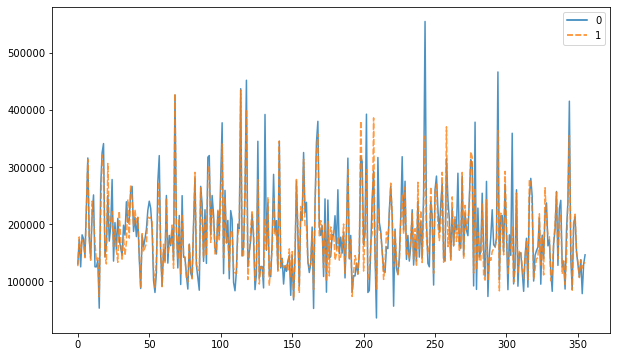

In [65]:
plt.figure(figsize=(10, 6))
rf = RandomForestRegressor(n_estimators=500, max_depth=None)
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_tst)
sn.lineplot(data=np.c_[np.exp(y_tst), np.exp(y_pred)], alpha=0.8)
plt.show()

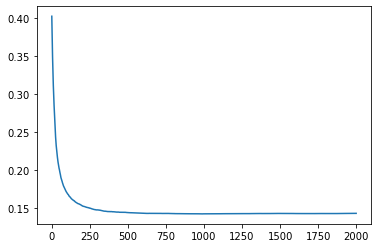

In [86]:
# 2. GBM
gbm = GradientBoostingRegressor(learning_rate=0.05, n_estimators=2000)
gbm.fit(X_tr, y_tr)
each_pred = gbm.staged_predict(X_tst)
score = map(lambda x: rmsle(np.exp(y_tst), np.exp(x)), each_pred)

sn.lineplot(data=list(score))
plt.show()

In [98]:
gbm = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05)
gbm.fit(X_tr, y_tr)
y_pred = gbm.predict(X_tst)
rmsle(np.exp(y_tst), np.exp(y_pred))

0.1456010552321817

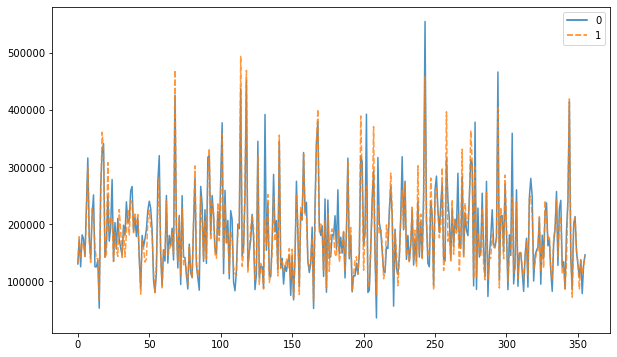

In [99]:
plt.figure(figsize=(10, 6))
sn.lineplot(data=np.c_[np.exp(y_tst), np.exp(y_pred)], alpha=0.8)
plt.show()

In [100]:
# 3. XGB
xg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05)
xg.fit(X_tr, y_tr)
y_pred = xg.predict(X_tst)

rmsle(np.exp(y_tst), np.exp(y_pred))

0.14503759563120538

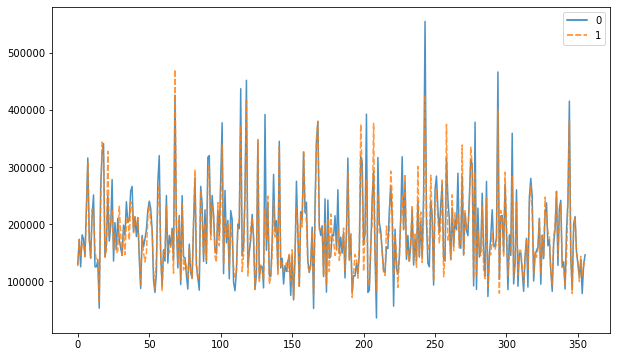

In [101]:
plt.figure(figsize=(10, 6))
sn.lineplot(data=np.c_[np.exp(y_tst), np.exp(y_pred)], alpha=0.8)
plt.show()

In [103]:
# 4. LGBM
lg = lgbm.LGBMRegressor(n_estimators=500, learning_rate=0.05)
lg.fit(X_tr, y_tr)
y_pred = lg.predict(X_tst)

rmsle(np.exp(y_tst), np.exp(y_pred))

0.14289821936888383

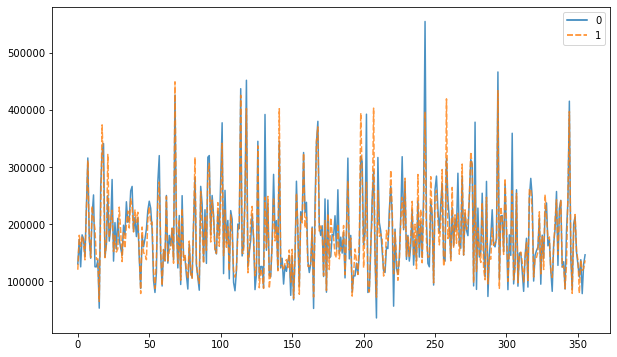

In [104]:
plt.figure(figsize=(10, 6))
sn.lineplot(data=np.c_[np.exp(y_tst), np.exp(y_pred)], alpha=0.8)
plt.show()

In [105]:
nn = MLPRegressor(max_iter=1000)
nn.fit(X_tr, y_tr)
y_pred = nn.predict(X_tst)

rmsle(np.exp(y_tst), np.exp(y_pred))

0.6789863775824496

In [106]:
lg = lgbm.LGBMRegressor(n_estimators=500, learning_rate=0.05)
lg.fit(X_tr, y_tr)
y_pred = lg.predict(df_tst_pca)
y_pred = np.exp(y_pred)

y_pred.shape

(1459,)

In [110]:
tst["SalePrice"] = y_pred

tst[["Id", "SalePrice"]].head()

,Id,SalePrice
0,1461,125998.330159
1,1462,143187.010432
2,1463,175375.196607
3,1464,184498.398709
4,1465,195007.165396


In [111]:
with open("house_price_submission.csv", "wb") as f:
    tst[["Id", "SalePrice"]].to_csv(f, index=False)

제출 결과 0.16058 의 RMSLE로 약 3000등의 결과가 나왔다.